In [736]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [737]:
embedding_vecs = pd.read_csv('C:/Users/Venia/ada_projects/quote_embedding.csv')

In [818]:
cq = pd.read_csv("/ada/projects/venia2021/data/quotebank/climate_quotes_topics.csv")

In [739]:
news_counts = pd.read_csv("/ada/projects/venia2021/data/quotebank/news_counts.csv")

In [740]:
# convert to ints
embedding_vecs[list(range(150))] = embedding_vecs[[str(k) for k in range(150)]]
embedding_vecs.drop([str(k) for k in range(150)], axis = 1, inplace=True)

/h/224/venia/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:3636: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



In [741]:
topic_info = pd.read_csv("/ada/projects/venia2021/data/quotebank/issues_by_news_site2.csv")

In [742]:
topic_info.columns = ['domain','topic','id','count']

In [743]:
news_counts.columns = ['domain','total_count']



In [744]:
# first we'll define the climate change vector
# this will be the weighted average of the vecs for the locations climate change invoked

climate_change_dist = topic_info.groupby('domain')['count'].sum().reset_index()


In [745]:
climate_change_dist = climate_change_dist.merge(news_counts)

In [746]:
climate_change_dist['proportion'] = climate_change_dist['count'] / climate_change_dist['total_count'] 



In [747]:
# we note that sometimes that proportion can be greater than 1. 
# this is because when we built the total count we took counts if the speaker was None
# it will be too computationally intensive to rerun.
# however, this should work as a good estimate 




In [748]:
climate_change_dist['count'] = climate_change_dist.apply(lambda x: min(x['count'], x['total_count']), axis = 1)

In [749]:
climate_change_dist['climate_score'] = climate_change_dist.apply(lambda x: np.log(x['count']) * x['proportion'], axis = 1)

In [750]:
# this idea to embed topics was taken from Rachel Kim's work on reddit and UBI. 

def define_vec(embedding, frequencies, merge_col):
    """embedding must have cols for each dimension
    frequencies must be in the form index, count"""
    df = embedding.merge(frequencies, on = merge_col, how = 'left')
    N = frequencies['count'].sum()
    for k in range(150):
        df[k] = df[k] * df['climate_score'] / N
    vec = df[range(150)].sum()
    return vec

def similarity_vec_embedding(embedding,vec,name):
    """embedding should be dataframe, vec should be series"""
    scores = cosine_similarity(embedding[range(150)].values, vec.values.reshape(1,-1))
    embedding2 = embedding.copy()
    embedding2[name] = scores
    embedding2 = embedding2.sort_values(by = name, ascending=False)
    return embedding2

In [751]:
climate_vec = define_vec(embedding_vecs,climate_change_dist, 'domain')


In [752]:
climate_vec = climate_vec / np.linalg.norm(climate_vec)

In [753]:
# normalize the vecs


In [754]:
embedding2 = similarity_vec_embedding(embedding_vecs, climate_vec, 'climate_projection')

In [755]:
embedding2 = embedding2.sort_values(by='climate_projection', ascending=False)

In [756]:
# for each of the subtopics 
# define a vector 
topic_info2 = topic_info.merge(news_counts)
topic_info2['proportion'] = topic_info2['count'] / topic_info2['total_count']

In [757]:
topics = topic_info2.topic.unique()
dic = {}
for t in topics:
    temp_topic = topic_info2[topic_info2['topic'] == t]
    temp_topic['climate_score'] = temp_topic.apply(lambda x: np.log(x['count']) * x['proportion'], axis= 1)
    vec = define_vec(embedding_vecs,temp_topic, 'domain').values
    dic[t] = vec

/h/224/venia/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [758]:
embedding = embedding2.copy()
for t in topics:
    embedding = similarity_vec_embedding(embedding, pd.Series(dic[t]), t)

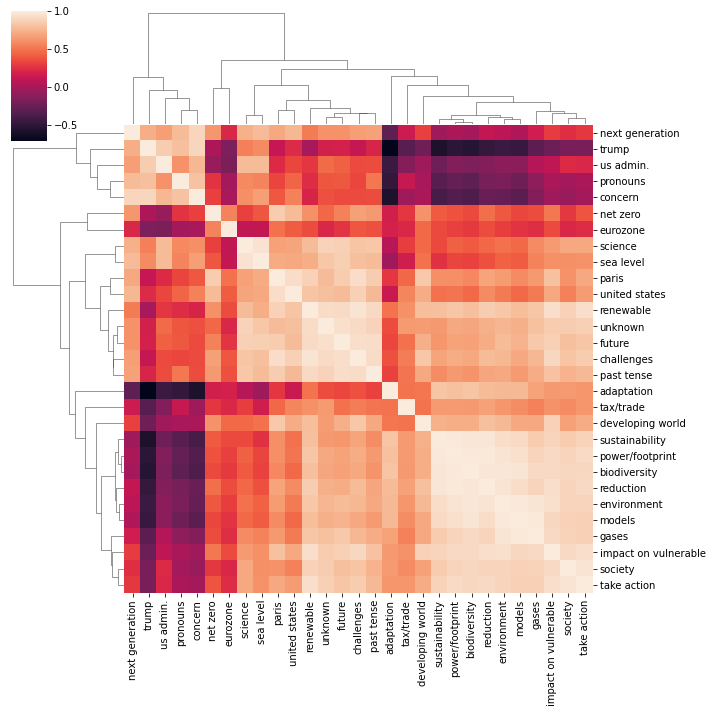

In [759]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.clustermap(embedding[topics].corr())

In [783]:
topics2 = ['next generation','trump','us admin.','net zero','eurozone','science','sea level','tax/trade','environment','gases','society']

In [784]:
for t in topics:
    embedding[t+"_"] = embedding[t] - embedding['climate_projection']

In [790]:
sites = ['foxnews.com','cnn.com','breitbart.com','nytimes.com','elle.com','time.com']

In [791]:
embedding_temp = embedding[embedding['domain'].isin(sites)]

In [792]:
cols = [k+"_" for k in topics2]

In [793]:
t = embedding_temp.melt(id_vars = 'domain',value_vars = topics2)

In [794]:
import plotly.express as px
from kaleido.scopes.plotly import PlotlyScope
scope = PlotlyScope()

fig = px.scatter(t,
                 x="value",
                 y="variable",
                 opacity=0.5,
                 color="domain",
                 labels=dict(dimension="",value="Variance",variable="Dimension"))
args = {
    "font":{"size": 23},
    "height": 800,
    "width": 1000,    
    "template":"simple_white",
    "yaxis_type": 'category',
    "showlegend": True,
    "yaxis":{"showline": False},
}
    
fig.update_traces(marker={'size': 15})
fig.update_layout(**args)
# with open("/u/venia/dimension_variance.pdf", "wb") as f:
#     f.write(scope.transform(fig, format="pdf"))
# fig.write_html("/ada/projects/venia2021/data/quotebank/sample_plot.html")
# fig.write_image("/u/venia/partisan_variance.png") 

## Here I try to define my own "cultural dimensions"

In [796]:
# we'll use the PMI for weights

def pmi(dff, x, y):
    df = dff.copy()
    df['f_x'] = df.groupby(x)[x].transform('count')
    df['f_y'] = df.groupby(y)[y].transform('count')
    df['f_xy'] = df['count']
    df['pmi'] = np.log(len(df.index) * df['f_xy'] / (df['f_x'] * df['f_y']) )
    return df

In [797]:
import numpy as np 

def create_cultural_vec(embedding, seeds1, seeds2):
    left_ = np.zeros(150)
    right_ = np.zeros(150)
    
    vecs2 = embedding[embedding['domain'].isin(seeds1)][range(150)].values
    vecs1 = embedding[embedding['domain'].isin(seeds2)][range(150)].values
    
    n1 = len(seeds1)
    n2 = len(seeds2)
    for k in vecs1:
        left_ += k
    left_ = left_/n1
    for j in vecs2:
        right_ += j
    right_ = right_/ n2
    left_ = left_ / np.linalg.norm(left_)
    right_ = right_/np.linalg.norm(right_)

    vec_dif = right_ - left_
    vec_dif = vec_dif / np.linalg.norm(vec_dif)
    return vec_dif

In [798]:
male_female = create_cultural_vec(embedding, ['mensxp.com'], ['elle.com'])

In [799]:
cosine_similarity_p = pairwise.cosine_similarity(embedding[range(150)].values, male_female.reshape(1,-1))


In [800]:
embedding['male_female'] = cosine_similarity_p

In [801]:
old_young = create_cultural_vec(embedding, ['teenvogue.com','seventeen.com'], ['vogue.com'])

In [802]:
old_young_sim = pairwise.cosine_similarity(embedding[range(150)].values, old_young.reshape(1,-1))


In [803]:
embedding['old_young'] = old_young_sim

## Table for the top 10 most and least similar sites to climate change

In [820]:
cq['domain'] = cq['domains']
cq.drop('domains',axis=1,inplace=True)
cq['domain'] = cq['domain'].apply(lambda x: eval(x))
cq = cq.explode('domain')

In [821]:
embedding2 = embedding.merge(cq.groupby('domain')['quoteID'].count().reset_index(), how = 'left')

In [822]:
print(embedding2[['domain','climate_projection']].sort_values(by ='climate_projection',ascending=False).head(10).to_html())



<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>domain</th>
      <th>climate_projection</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>295</th>
      <td>yaleclimateconnections.org</td>
      <td>0.890519</td>
    </tr>
    <tr>
      <th>303</th>
      <td>climatecentral.org</td>
      <td>0.884039</td>
    </tr>
    <tr>
      <th>345</th>
      <td>mongabay.com</td>
      <td>0.830271</td>
    </tr>
    <tr>
      <th>318</th>
      <td>greenbiz.com</td>
      <td>0.830028</td>
    </tr>
    <tr>
      <th>300</th>
      <td>desmogblog.com</td>
      <td>0.829195</td>
    </tr>
    <tr>
      <th>239</th>
      <td>treehugger.com</td>
      <td>0.807636</td>
    </tr>
    <tr>
      <th>325</th>
      <td>blueandgreentomorrow.com</td>
      <td>0.804560</td>
    </tr>
    <tr>
      <th>323</th>
      <td>carbonbrief.org</td>
      <td>0.802666</td>
    </tr>
    <tr>
      <th>284</th>
      <td>theenergycollecti

In [823]:
print(embedding2[['domain','climate_projection']].sort_values(by ='climate_projection',ascending=True).head(10).to_html())


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>domain</th>
      <th>climate_projection</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>7813</th>
      <td>wdef.com</td>
      <td>-0.473759</td>
    </tr>
    <tr>
      <th>7768</th>
      <td>usatoday.com</td>
      <td>-0.457636</td>
    </tr>
    <tr>
      <th>7815</th>
      <td>valleymorningstar.com</td>
      <td>-0.448353</td>
    </tr>
    <tr>
      <th>7796</th>
      <td>brownsvilleherald.com</td>
      <td>-0.442978</td>
    </tr>
    <tr>
      <th>7708</th>
      <td>thecourierexpress.com</td>
      <td>-0.439536</td>
    </tr>
    <tr>
      <th>7802</th>
      <td>fox13memphis.com</td>
      <td>-0.438362</td>
    </tr>
    <tr>
      <th>7773</th>
      <td>10thousandcouples.com</td>
      <td>-0.437220</td>
    </tr>
    <tr>
      <th>7816</th>
      <td>abc-7.com</td>
      <td>-0.434763</td>
    </tr>
    <tr>
      <th>7814</th>
      <td>wsmv.c

## Generalist-Specialist Score
Inspired from https://www.cs.toronto.edu/~ashton/pubs/actdiv-www2019.pdf

In [966]:
cq = cq.merge(embedding[['domain','cluster','score'] + list(range(150))])

In [967]:
cq = cq.drop_duplicates(subset= 'quoteID')


In [968]:
mean_vecs = cq.groupby('topic')[list(range(150))].apply(lambda x: np.mean(x) / np.linalg.norm(np.mean(x)))

In [969]:
topics = cq.topic.unique()
gs_scores = {}
for t in topics:
    mean_vec = mean_vecs[mean_vecs.index == t]
    p = cq[cq['topic'] == t][range(150)]
    c = cosine_similarity(p, mean_vec.values.reshape(1,-1)).mean()
    gs_scores[t] = c

In [970]:
gs_score = pd.DataFrame.from_dict(gs_scores, orient= 'index').sort_values(by=0, ascending=True)

In [971]:
gs_score.columns = ['gs_score']

In [973]:
print(gs_score.head(5).to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>gs_score</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>society</th>
      <td>0.149831</td>
    </tr>
    <tr>
      <th>concern</th>
      <td>0.153984</td>
    </tr>
    <tr>
      <th>reduction</th>
      <td>0.155351</td>
    </tr>
    <tr>
      <th>power/footprint</th>
      <td>0.164052</td>
    </tr>
    <tr>
      <th>biodiversity</th>
      <td>0.167376</td>
    </tr>
  </tbody>
</table>


In [974]:
print(gs_score.sort_values(ascending=False, by='gs_score').head(5).to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>gs_score</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>eurozone</th>
      <td>0.328310</td>
    </tr>
    <tr>
      <th>models</th>
      <td>0.316398</td>
    </tr>
    <tr>
      <th>tax/trade</th>
      <td>0.314999</td>
    </tr>
    <tr>
      <th>trump</th>
      <td>0.312403</td>
    </tr>
    <tr>
      <th>science</th>
      <td>0.276532</td>
    </tr>
  </tbody>
</table>


In [833]:
top_news_by_cluster = cq.groupby(['cluster', 'domain'])['quoteID'].count().sort_values(ascending=False).groupby('cluster').head(1)

In [834]:
top_news2 = ['un.org','huffingtonpost.com','eurekaltert.org','indiatimes.com','theglobeandmail.com','nhl.com', 'enewspf.com','environmentalhealthnews.com','phys.org','euronews.com']

In [835]:
# extract the top newspaper from each cluster to see what issues it cares about
top_news = top_news_by_cluster.reset_index()['domain'].values

temp_news = embedding[embedding['domain'].isin(top_news2)]

In [836]:
top_news2

['un.org',
 'huffingtonpost.com',
 'eurekaltert.org',
 'indiatimes.com',
 'theglobeandmail.com',
 'nhl.com',
 'enewspf.com',
 'environmentalhealthnews.com',
 'phys.org',
 'euronews.com']

In [837]:
scores = temp_news.melt(id_vars='domain',value_vars = topics2)

In [851]:
scores[scores['domain'] == 'un.org'].sort_values(by = 'value').head(1)['variable'].values[0]

'eurozone'

In [873]:
import plotly.express as px
from kaleido.scopes.plotly import PlotlyScope
scope = PlotlyScope()

fig = px.scatter(scores,
                 x="value",
                 y="domain",
                 opacity=0.5,
                 color="variable",
                 labels=dict(dimension="",value="Projection",variable="Topic"),
                )
args = {
    "font":{"size": 23},
    "height": 500,
    "width": 800,    
    "template":"simple_white",
    "yaxis_type": 'category',
    "showlegend": False,
    "yaxis":{"showline": False, 'tickmode': 'linear', 'title':''},
}

font_color = '#656565'


for i, site in enumerate(scores['domain'].unique()):
    y = i + 0.3

    top1 = scores[scores['domain'] == site].sort_values(by = 'value').head(1)
    top1_x = top1['value'].values[0]
    top1_name =  top1['variable'].values[0]
    
    bottom1 = scores[scores['domain'] == site].sort_values(by = 'value').tail(1)
    bottom1_x = bottom1['value'].values[0]
    bottom1_name =  bottom1['variable'].values[0]

    fig.add_annotation(x=top1_x, y=y,
                text=top1_name,
                showarrow=False,
                arrowhead=2,
                font_size = 11,
                font_color = font_color)   
    
    fig.add_annotation(x=bottom1_x, y=y,
                text=bottom1_name,
                showarrow=False,
                arrowhead=2,
                font_size = 11,
                font_color = font_color) 

fig.update_traces(marker={'size': 15})
fig.update_layout(**args)
fig.write_html("/ada/projects/venia2021/data/quotebank/news_interests.html")


# Show if climate change was polarized overtime

In [854]:
cq['date'] = pd.to_datetime(cq['date'])
cq['month_date'] = cq['date'].dt.strftime('%Y-%m')

In [855]:
polarization = cq.dropna(subset=['score'])

polarization['partisan_bin'] = pd.cut(polarization['score'], bins = 20, labels = False)

/h/224/venia/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [856]:
p_grouped = polarization.groupby(['month_date','partisan_bin'])['score'].count().reset_index()
p_grouped['total_count'] = p_grouped.groupby('month_date')['score'].transform('sum')
p_grouped['proportion'] = p_grouped['score'].divide(p_grouped['total_count'])

In [874]:
import plotly.express as px


fig = px.bar(p_grouped, x="month_date", y="proportion", color="partisan_bin", title="Polarization of climate change", color_continuous_scale = 'Bluered')
args = {
    "font":{"size": 20},
    "yaxis":{"showline": True, 'tickmode': 'linear', 'title':'Proportion'},
    "xaxis": {'title': ""},
    "showlegend": False,
}
fig.update_traces(marker_showscale=False)

fig.update_layout(**args)
fig.update(layout_coloraxis_showscale=False)
fig.write_html("/ada/projects/venia2021/data/quotebank/polarization.html")


In [ ]:
# NORMALIZE BY POPULARITY OF BIN

## Polarization histograms by topic

In [859]:
top_topics = polarization.groupby('topic')['quoteID'].count().sort_values(ascending=False).index

In [871]:
top_25_topics = ['power/footprint', 'gases', 'models', 'sustainability',
       'impact on vulnerable', 'adaptation', 'renewable', 'challenges',
       'science', 'next generation', 'us admin.', 'trump', 'united states', 'tax/trade', 'eurozone', 'paris',
       'developing world', 'biodiversity', 'sea level', 'environment',
       'society', 'future', 'net zero', 'concern', 'reduction']

In [ ]:
# PLOT THIS WITH Z-SCORE

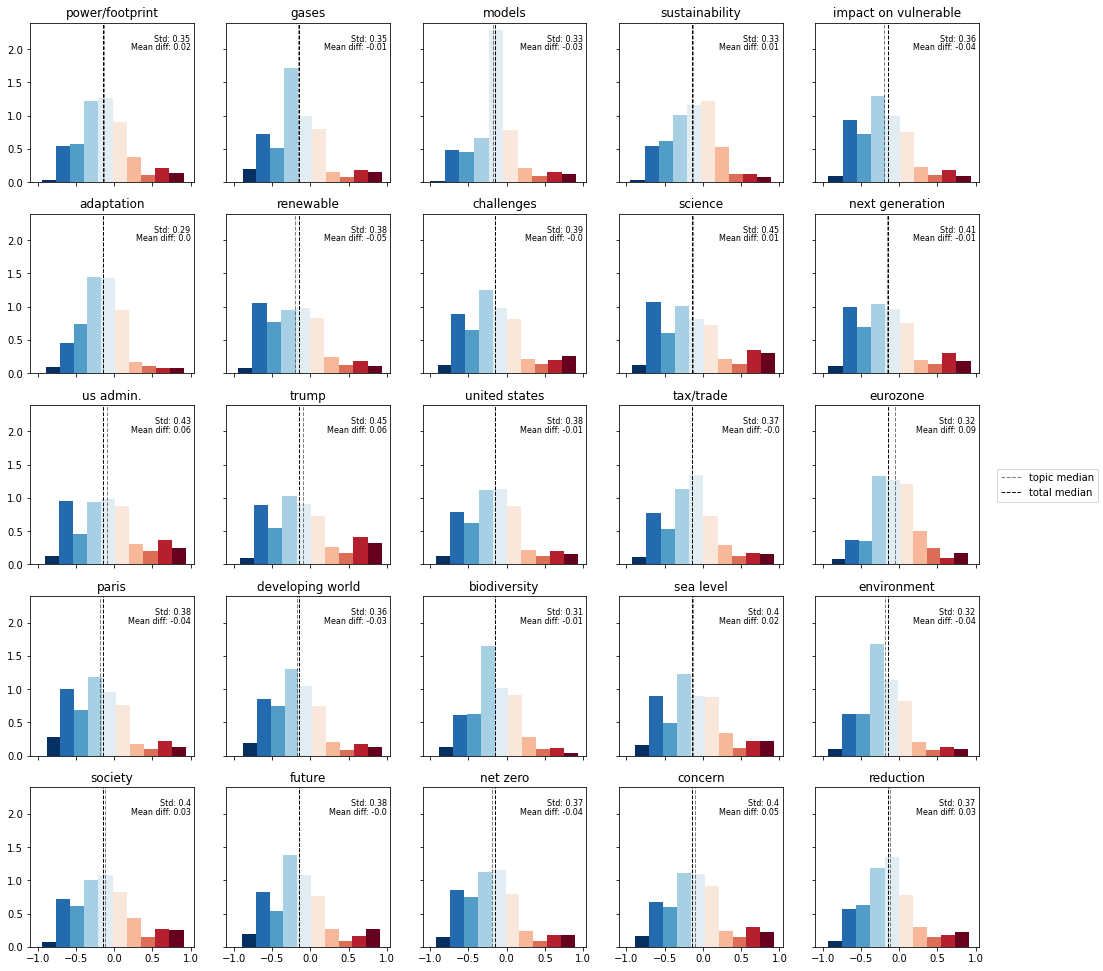

In [876]:
fig, axs=plt.subplots(5,5, figsize = (17,17), sharex = True, sharey=True)

median_line = polarization[polarization['topic'].isin(top_25_topics)]['score'].mean()
cm = plt.cm.get_cmap('RdBu_r')

for i, ax in enumerate(axs.flatten()):
    t = top_25_topics[i]
    temp = polarization[polarization['topic'] == t]
    n, bins, patches = ax.hist(temp['score'], bins = 10, density=True)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # scale values to interval [0,1]
    col = bin_centers - min(bin_centers)
    col /= max(col)

    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))
        
    ax.axvline(temp['score'].mean(), color='k', linestyle='dashed',alpha = 0.5, linewidth=1, label = 'topic median')
    ax.axvline(median_line, color='k', linestyle='dashed', linewidth=1, label = 'total median')
    ax.set_title(t)
    ax.text(s = 'Std: {}'.format(temp['score'].std().round(2)), fontsize = 8, x = 1, y =2.12, ha = 'right')
    ax.text(s = 'Mean diff: {}'.format((temp['score'].mean() - median_line).round(2)), fontsize = 8, x = 1, y =1.99, ha = 'right')
    if i == 24:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc = 'right')
plt.savefig("/ada/projects/venia2021/data/quotebank/topic_distribution.png", dpi = 300, bbox_inches='tight')

## Compare climate change discussion to overall discussion

In [951]:

# Groups should be in format [{name:..., weights:...}] or [{name:...., score_col: (hist, bin_edges) }]
def many_densities(groups, dimen_list, data, bins=30, density_scaling_factor=5, figsize=(8,5), all_label="Difference"):
    n_groups = len(groups)
    n_dimens = len(dimen_list)
    fig, axs = plt.subplots(1, n_dimens, figsize=figsize)
    min_maxs = []
    for i, dimen in enumerate(dimen_list):
        ax = axs
        name = dimen
        ax.set_title(name, fontsize = 16)
        ax.set_frame_on(False)
        ax.tick_params(axis='x', labelrotation=90, labelsize = 14)
        if i == 0:
            ax.set_yticks(range(-1, n_groups + 1))
            group_labels = ["%s\nn=%s" % (group if type(group) is not dict else group["name"], "{:,}".format(round(sum(group['weights'])))) for i, group in enumerate(groups)]
            ax.set_yticklabels([None]+[all_label]  + group_labels, ha='right', fontsize=14)
        else:
            ax.set_yticks([])
        
        ax.set_ylim(-1, n_groups + 1)
        min_max = (np.min(data[dimen]), np.max(data[dimen]))
#         min_max = (-2.5, 2.5)
        min_maxs.append(min_max)
        ax.set_xlim(min_max[0], min_max[1])
#         if name == 'partisan-ness':
#             ax.set_xticks([-1,1.5,5])
#         else:
#             ax.set_xticks([-2.5,0,2.5])
        median = np.median(data[name])
        ax.axvline(median, color='black', linestyle='--', linewidth=1)
    weights = np.empty(len(data))
    for i, group in enumerate([None] + groups):
        if group is None:
            weights1 = groups[i-1].get('weights',None)
            weights2 = groups[i-2].get('weights', None)
        else:
            weights = group.get("weights", None)      
        for j, dimen in enumerate(dimen_list):    
            name = dimen
            if group is not None and name in group:
                hist, bin_edges = data[name]
            elif group is None:
                hist1, bin_edges1 = np.histogram(data[name], bins=bins, range=min_maxs[j], weights=weights1, density=False)
                hist2, bin_edges2 = np.histogram(data[name], bins=bins, range=min_maxs[j], weights=weights2, density=False)
                hist1 = hist1 / np.sum(hist1)
                hist2 = hist2 / np.sum(hist2)
                bin_edges = bin_edges1[:-1]
                bin_edges2 = bin_edges2[:-1]
                hist=hist1-hist2
            else:
                hist, bin_edges = np.histogram(data[name], bins=bins, range=min_maxs[j], weights=weights, density=False)
                hist = hist / np.sum(hist)
                bin_edges = bin_edges[:-1]
            scaling_factor = (min_maxs[j][1] - min_maxs[j][0]) * density_scaling_factor
            x = bin_edges[1:-1]
            y = (scaling_factor * hist) + i
            y = y[1:-1]
            score = 0.4
            # y = savgol_filter(y,7,5)
            if group is None:
#                 y = y*1.7
                axs.plot(x,y,color='black')
                score=0.8
                axs.fill_between(x, y, i, where=  y>=i, facecolor="#FFCB9E", alpha = score, interpolate = True)
                axs.fill_between(x, y, i, where = y<=i, facecolor="#A5C8E1", alpha = score, interpolate=True)
            else:
                axs.plot(x, y, color='black')
                axs.fill_between(x, y, i, alpha=score)

In [882]:
news_counts2 = news_counts.merge(embedding[['domain', 'score']]).dropna()

In [954]:
climate_quotes_g = cq.groupby('domain').agg({'quoteID': 'count', 'score':'mean'}).reset_index().dropna()

In [955]:
news_counts2.columns = ['domain','total_count_all','score']
climate_quotes_g.columns = ['domain','total_count','partisan_score']

In [956]:
climate_quotes_g = climate_quotes_g.merge(news_counts2[['domain','total_count_all']])

In [957]:
weights = [{"name": "Climate Related", "weights": climate_quotes_g['total_count'].values},{"name": "All quotes", "weights": climate_quotes_g['total_count_all'].values}]

In [960]:
dimen_list = ['partisan_score']


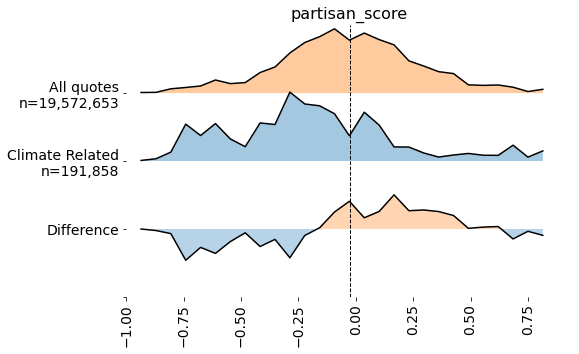

In [963]:
many_densities(weights,dimen_list, climate_quotes_g)
plt.savefig("/ada/projects/venia2021/data/quotebank/difference_plot.png", dpi = 300, bbox_inches = "tight")

### Connecting to wikidata


In [978]:
import glob
k = glob.glob('/ada/projects/venia2021/data/quotebank/*')
k = [j for j in k if  "snappy" in j]

In [1041]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.sql import SparkSession
from pyspark import SparkContext
import pandas as pd
import json
import glob
import os 

# import matplotlib.pyplot as plt
# spark = SparkSession.builder.config("spark.driver.memory", "700g")\
#     .config("spark.driver.maxResultSize", '0').config("spark.executor.memory", "700g")\
#     .config('spark.sql.autoBroadcastJoinThreshold', '-1').config('spark.local.dir','/ada/tmp').getOrCreate()

# wikidata = spark.read.load(k)

In [1015]:
names = spark.read.csv("/ada/projects/venia2021/data/quotebank/wikidata_labels_descriptions.csv.bz2", header=True)

In [1016]:
def extract_smallest_qid(qids):
    try: 
        if len(qids) > 1:
            vals = [int(k[1:]) for k in qids]
            vals.sort()
            response = f'Q{vals[0]}'
        else:
            response = qids[0]
        return response
    except:
        return None
extract_smallest_qid_udf = udf(extract_smallest_qid, IntegerType())

In [1017]:
# cq['qids'] = cq['qids'].apply(lambda x: eval(x))
cq['qid'] = cq['qids'].apply(lambda x: extract_smallest_qid(x))

In [1018]:
wikidata = wikidata.select(*['nationality','gender','occupation','id'])

In [1031]:
qids = cq[cq['qid']!="None"]['qid'].dropna()

In [1035]:
df = spark.createDataFrame(qids.reset_index())
df = df.withColumn('id', col('qid'))

In [1037]:
joined = df.join(wikidata, how = 'inner')